# Experiment & Estimate => Proposal (Recommendation)

---



## Hypothesis 
* **A) It's better to use `jpg` format instead of `png` because it's smaller file size (in average)**
    - Smaller file size: Better for `data bandwidth`
    - Samller file size: Better for `storage` (i.e. storing `100K images` in embedded database)


* **B) There won't be significant `image quality degradation` **
    - No significant change for human eyes by switching the image format from `png` to `jpg`.
    - Note: Thhis would depend on the conversion method (esp `quality`)

## Goal
1. Get estimations below using `bootstrap & confidence interval:
    - Get average image byte sizes of `png` and `jpg` (for `bandwidth` consideration)
    - Get estiamted total byte size for 10K images between `png` and `jpg` (for `strage` consideration) 
    
    
2. Visualize the results

## Datasets
* Station logo images (`png`) in US (which are available in system as of Oct, 2018) - approximately 13K 



## Action Plan
* **ESTIMATION**:
    * Step0) Load station logo ids for radio stations (in US) from the csv file below:
        - `logo_id__us.csv`: the query results from backend database (sql result)
    * Step1) Get `Sample`: Randomly pick 200 stations from the dataset
    * Step2) Download station logo images (in `.png`) for the sample.
    * Step3) Convert image files from `png` to `jpg
    * Step4) Populate image data (i.e. bytes, format, mode)
    * Step5) Run Bootstrap function & Confidence internval
        - Estimate an average size of image (for data bandwidth) 
        - Estimate the total size of 10K images (for embedded database)


* **IMAGE QUALITY CHECK**:
    * Compare `png` and `jpg` image files for the same radio station
        - see if there are any noticable `image quality degradation`(from human eyes on the screen).

## Use Case Diagram
![use case diagram][use_case_diagram]

[use_case_diagram]: ./resource/Logo_UseCase.png "test"

---
# **ESTIMATION**:

### Step0) Load station logo ids for radio stations (in US) from the csv file below:
- `logo_id__us.csv`: the query results from backend database (sql result)

In [1]:
# Create DataFrame from radio station data (in US) csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import os
import re

In [2]:
# direcotory path
path_dir_csv = "./data/csv/"      # csv file location 

# read csv file
csv_file_path = path_dir_csv + 'logo_id__us.csv'
df_station = pd.read_csv(csv_file_path)
df_station.head()

,logo_id,name,band,station_id,is_image_available
0,GNCTX0A4N003334,106.9 XFM Rocks,FM,GN38B7X17KZFVZN,1
1,GN9VDZHCNT0BZEF,90.7 The Music FM,FM,GN3G5TGT5JK6T6M,1
2,GN9QWQHZMQ5EKPN,AM 760 The Reason,AM,GN4E2KW3P6WST73,1
3,GN9E4D6X157CB33,WLRH Classical HD 2,FM,GN2R44PYWRJ3KBW,1
4,GNCGDEA0ZTTWC14,WNRX 99.3,FM,GNDJDPCDZ42A5YF,1


In [3]:
df_station.is_image_available.value_counts()

1    15118
0      740
Name: is_image_available, dtype: int64

In [4]:
# clean-up DataFrame
df_station = df_station.drop_duplicates(subset='logo_id', keep="first")
df_station_with_logo = df_station[df_station.is_image_available==1].drop('is_image_available', 1)
df_station_with_logo.describe()

,logo_id,name,band,station_id
count,13277,13277,13277,13277
unique,13277,12023,2,13277
top,GN2JDMDP9APK6N9,Radio 74 Internationale,FM,GN0NEMEGP3F8C6X
freq,1,57,10467,1


### Step1) Get `Sample`: Randomly pick 200 stations from the dataset

In [5]:
# Sampling radio stations
df_sample = df_station_with_logo.sample(200,replace=False)
df_sample.head()

,logo_id,name,band,station_id
5450,GN38QJ9XGG5722C,Classic Hits 93.3,FM,GN9J7FS09DPSHEZ
9540,GN5FH5V7F8G7526,MegaTalk 920,AM,GN03KJ67FMAYRNQ
576,GN61J47GN73AHBV,KVNF Community Radio,FM,GN5VNAERV7QP241
8672,GN4SDMER7F4DK7H,KTXK 91.5 FM,FM,GNCZX69VHZ1GKED
13728,GN42RVJJVQ3GXMD,WBEZ 91.5,FM,GN3CZ2YXJ06FQNZ


In [6]:
df_sample.describe()

,logo_id,name,band,station_id
count,200,200,200,200
unique,200,200,2,200
top,GN3C9XEM5XWC3VT,Radio ZOE 1430 AM,FM,GN6EYSV92EPR1PZ
freq,1,1,153,1


### Step2) Download station logo images (in `.png`) for the sample.

#### Prepare directories to store logo images

In [7]:
# Prepare directories to store logo images 

# direcotory path
path_dir_png = "./data/logo_300/png/" # From (Existing png file path)
path_dir_jpg = "./data/logo_300/jpg/" # To (Newly generated jpg path)
list_dir = [path_dir_png,path_dir_jpg]

def prepare_dir(list_dirctory):
    '''
    prepare directory. 
        if not exist, create new directory 
        if exists, do nothing
    
    '''
    for directory in list_dirctory:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('Woohoo! Directory {} is created!!'.format([directory]))
        else:
            print('Good news! Directory {} already exists. No new directory is created.'.format([directory]))
    
    
# exectute
prepare_dir(list_dir)

Good news! Directory ['./data/logo_300/png/'] already exists. No new directory is created.
Good news! Directory ['./data/logo_300/jpg/'] already exists. No new directory is created.


#### Populate list of URLs to fetch logos

In [8]:
# craft logo urls to fetch
logo_urls = [] # 
# logo_id is in sample DataFrame
for logo_id in df_sample.logo_id:
    logo_urls.append("http://tmsimg.com/assets/rsid_logo_" + logo_id + ".png?w=300")
len(logo_urls)

200

#### Download .png logo files if not exists 
   * note: this operation will take long time if the target images have not been downloaded for the first time

In [9]:
# Download station logo .png files
import re, urllib.request
from pathlib import Path

# Loop urllib
download_count = 0
exist_count = 0
success_count = 0
error_count = 0
total_count = 0

#image_available = []  ## some images may not be available in image cloud service

# Loop
for index, url in enumerate(logo_urls):
    try:
        # parse url by using re
        pattern = r'/|\.'
        # ex) ['http:', '', 'tmsimg', 'com', 'assets', 'rsid_logo_GN5BA19N7HEXAWT', 'png?w=300']
        filename = (re.split(pattern,url)[-2]) 
        
        #print(filename)
        # <path_dir_pgn>/rsid_logo_GN5BA19N7HEXAWT.png
        #
        # fetch if the target png file doesn't exist yet
        target_file = Path(path_dir_png + filename + ".png")
        if target_file.exists() == False:
            urllib.request.urlretrieve(url, path_dir_png + filename + ".png") 
            download_count += 1
        else:
            exist_count += 1
        success_count += 1
        #image_available.append(1)
    except IOError:
        print("error occured...index[{}]".format(index), url)
        error_count += 1        
        #image_available.append(0)        
    total_count += 1
    
# Print
print('--------')
print('{} image URLs are processed:'.format(total_count))
print('* {} png station logos are processed successfully:'.format(success_count))
print(' ++ {} png station logos are newly downloaded at "{}"'.format(download_count, path_dir_png))
print(' ++ {} png station logos already exist (and available) at "{}"'.format(exist_count, path_dir_png))
print('* {} images are failed to fetch'.format(error_count))
print('--------')

--------
200 image URLs are processed:
* 200 png station logos are processed successfully:
 ++ 184 png station logos are newly downloaded at "./data/logo_300/png/"
 ++ 16 png station logos already exist (and available) at "./data/logo_300/png/"
* 0 images are failed to fetch
--------


### Step3) Convert image files from `png` to `jpg`

#### Convert png images of `sample` stations (Convert by using `PIL` with `format='JPEG'`, `quality = 95`, `optimize=True` options)

In [10]:
# Convert png images to jpg images
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# variable
success_count = 0
error_count = 0
convert_count = 0
exist_count = 0
total_count = 0 
is_jpg_image_available = []  ## some images may not be available in image cloud service

for index, logo_id in enumerate(df_sample['logo_id'].tolist()):
    png_file = 'rsid_logo_' + logo_id + '.png'
    jpg_file = 'rsid_logo_' + logo_id + '.jpg'

    source_file_path = Path(path_dir_png + png_file)
    target_file_path = Path(path_dir_jpg + jpg_file)
    # Convert if the target png file doesn't exist yet
    if target_file_path.exists() == False:
        # convert
        try: 
            im = Image.open(source_file_path)
            # If not "RGB" mode, convert to "RGB"
            if im.mode != "RGB":
                im = im.convert("RGB")            
            im.save(target_file_path, format='JPEG', quality=95, optimize=True) ## quality=95 is best 
            convert_count += 1
        except IOError:
            print("cannot convert...index[{}]".format(index), source_file_name)
            error_count += 1
        success_count += 1 
    else:
        exist_count += 1        
    total_count += 1 

# Print
print('--------')
print('{} png logo_id are processed'.format(total_count))
print('* {} png station logos are processed successfully:'.format(success_count))
print(' ++ {} jpg station logos are newly generated from png logos. Available at "{}"'.format(convert_count,path_dir_jpg))
print(' ++ {} jpg logos already exist at "{}"'.format(exist_count, path_dir_png))
print('* {} images are failed to convert'.format(error_count))
#print(image_available)
print('--------')

--------
200 png logo_id are processed
* 184 png station logos are processed successfully:
 ++ 184 jpg station logos are newly generated from png logos. Available at "./data/logo_300/jpg/"
 ++ 16 jpg logos already exist at "./data/logo_300/png/"
* 0 images are failed to convert
--------


### Step4) Populate image data (i.e. bytes, format, mode)

In [11]:
# Populate static data
def generate_image_attr_data_set(path_dir):
    '''
    generate_image_attr_data_set(path_dire)

    * arg: path to the directory where contains image files (radio station logo)
    * return: list 
    * note: The expected radio station logo file name is "rsid_logo_<logo_id>.png"
        example) "rsid_logo_GN0C9PV3TG832YS.png"
    '''
    # variables
    image_attr_data_set = []
    tmp_dict = {}

    # Iterate
    for logo_file in os.listdir(path_dir):
        f, e = os.path.splitext(logo_file)
        if e == '.png' or e == '.jpg' :        
            try:
                # graceonte_id
                logo_id = re.split('_|\.',logo_file)[2]
                # bytes
                im_bytes = os.stat(path_dir + logo_file).st_size

                # <image data>
                im = Image.open(path_dir + logo_file)
                # format
                im_format = im.format
                # size 
                im_size = im.size
                # mode
                im_mode = im.mode

                tmp_dict = {
                    "logo_id": logo_id,
                    "bytes": im_bytes,
                    "format": im_format,
                    "size": im_size,
                    "mode": im_mode
                             }
                #print(tmp_dict)
                image_attr_data_set.append(tmp_dict)

            except IOError:
                print("error occured...", logo_file)  
    #print(image_attr_data_set)
    return image_attr_data_set


# Generate DataFrames storing image attribute data
# png
df_im_att_png = pd.DataFrame(generate_image_attr_data_set(path_dir_png))
# jpg
df_im_att_jpg = pd.DataFrame(generate_image_attr_data_set(path_dir_jpg))

# merge
df_im_att_all = pd.merge(df_im_att_png,df_im_att_jpg, how='inner',on='logo_id', suffixes=('_png','_jpg'))
df_im_att_all.describe()
df_im_att_all.head()

,bytes_png,format_png,logo_id,mode_png,size_png,bytes_jpg,format_jpg,mode_jpg,size_jpg
0,29566,PNG,GN000BKKAPHK3P4,RGB,"(300, 300)",14608,JPEG,RGB,"(300, 300)"
1,60738,PNG,GN000TX40XCZC8G,RGB,"(300, 300)",27258,JPEG,RGB,"(300, 300)"
2,22731,PNG,GN00JXTR5W1S37X,RGB,"(300, 300)",18194,JPEG,RGB,"(300, 300)"
3,32618,PNG,GN00RMSJXQM787X,RGB,"(300, 300)",17691,JPEG,RGB,"(300, 300)"
4,69223,PNG,GN00RWGZFGQW57Z,RGB,"(300, 300)",27670,JPEG,RGB,"(300, 300)"


In [12]:
# Merge df_sample & df_im_att  
df_sample_data = pd.merge(df_sample,df_im_att_all, how='left',on='logo_id')
df_sample_data.head()


,logo_id,name,band,station_id,bytes_png,format_png,mode_png,size_png,bytes_jpg,format_jpg,mode_jpg,size_jpg
0,GN38QJ9XGG5722C,Classic Hits 93.3,FM,GN9J7FS09DPSHEZ,49912,PNG,RGB,"(300, 300)",26087,JPEG,RGB,"(300, 300)"
1,GN5FH5V7F8G7526,MegaTalk 920,AM,GN03KJ67FMAYRNQ,37471,PNG,RGB,"(300, 300)",16023,JPEG,RGB,"(300, 300)"
2,GN61J47GN73AHBV,KVNF Community Radio,FM,GN5VNAERV7QP241,11702,PNG,L,"(300, 300)",15234,JPEG,RGB,"(300, 300)"
3,GN4SDMER7F4DK7H,KTXK 91.5 FM,FM,GNCZX69VHZ1GKED,18924,PNG,L,"(300, 300)",18564,JPEG,RGB,"(300, 300)"
4,GN42RVJJVQ3GXMD,WBEZ 91.5,FM,GN3CZ2YXJ06FQNZ,33449,PNG,RGB,"(300, 300)",23024,JPEG,RGB,"(300, 300)"


In [13]:
dataset = df_sample_data[['bytes_png','bytes_jpg']].sort_values(by='bytes_png').reset_index().drop(columns="index")

[26 50 40 34 24  9  7  7  2  1]


Text(0.5,0,'Bytes')

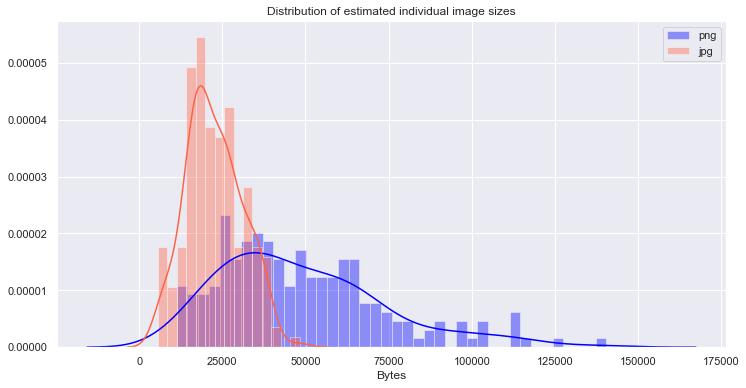

In [14]:
count, bin_edges = np.histogram(dataset['bytes_png'])
print(count)
# Visualize
plt.figure(figsize=(12,6))
sns.distplot(dataset['bytes_png'],label='png', color="blue", bins=40)
sns.distplot(dataset['bytes_jpg'],label='jpg', color="tomato", bins=15)
plt.title("Distribution of estimated individual image sizes")
plt.legend()
plt.xlabel('Bytes')


Text(0.5,0,'nth logo')

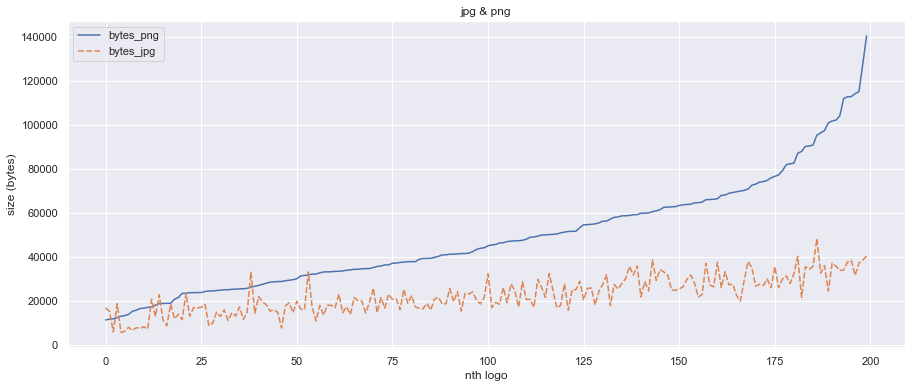

In [15]:
# line plot
plt.figure(figsize=(15,6))
sns.lineplot(data=dataset, sort=True)
plt.title('jpg & png')
plt.ylabel('size (bytes)')
plt.xlabel('nth logo')

Text(0.5,0,'N-th image')

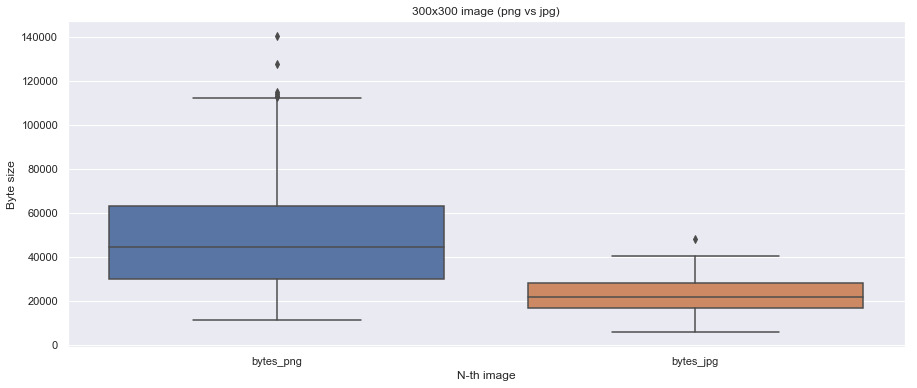

In [16]:
# box plot
plt.figure(figsize=(15,6))
sns.boxplot(data=dataset)
plt.title('300x300 image (png vs jpg)')
plt.ylabel('Byte size')
plt.xlabel('N-th image')

### Step5) Run Bootstrap function & Confidence internval
        - Estimate an average size of image (for data bandwidth) 
        - Estimate the total size of 10K images (for embedded database)

#### Estimate an average size of image (for data bandwidth) 

In [17]:
import numpy as np

In [18]:
# Bootstrapping - png, jpg
bootstrap_dist_png_mean = sns.algorithms.bootstrap(df_sample_data.bytes_png, n_boot=9999, func=np.mean)
bootstrap_dist_jpg_mean = sns.algorithms.bootstrap(df_sample_data.bytes_jpg, n_boot=9999, func=np.mean)
bootstrap_dist_diff_mean = sns.algorithms.bootstrap(df_sample_data.bytes_jpg - df_sample_data.bytes_png, n_boot=9999, func=np.mean)
bootstrap_dist_ratio_mean = sns.algorithms.bootstrap(df_sample_data.bytes_jpg / df_sample_data.bytes_png, n_boot=9999, func=np.mean)

Text(0.5,0,'Bytes')

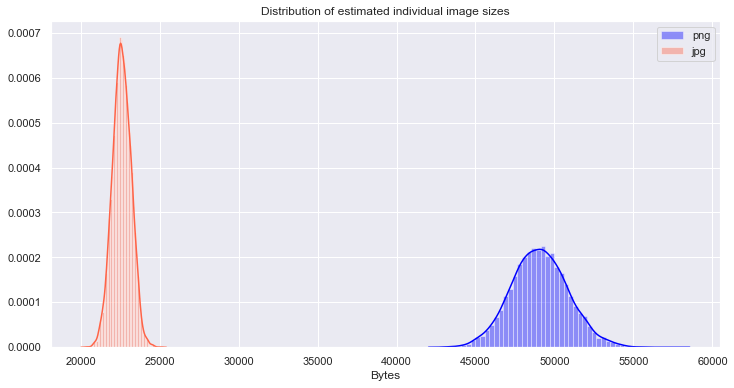

In [19]:

data_png = bootstrap_dist_png_mean 
data_jpg = bootstrap_dist_jpg_mean 

# Visualize
plt.figure(figsize=(12,6))
sns.distplot(data_png,label='png', color="blue")
sns.distplot(data_jpg,label='jpg', color="tomato")
plt.title("Distribution of estimated individual image sizes")
plt.legend()
plt.xlabel('Bytes')


Text(0.5,0,'Ratio')

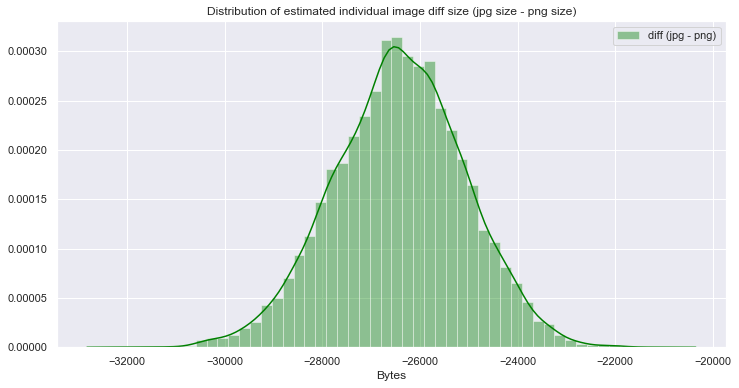

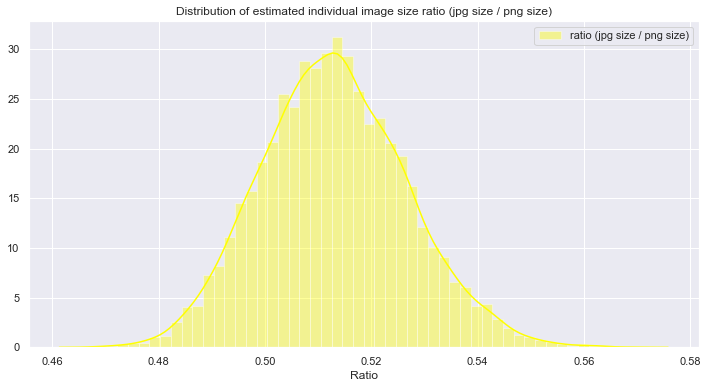

In [20]:
# data for visualization & percentile calc
data_diff = bootstrap_dist_diff_mean
data_ratio = bootstrap_dist_ratio_mean

# Visualize
plt.figure(figsize=(12,6))
sns.distplot(data_diff, label='diff (jpg - png)', color='green')
plt.title("Distribution of estimated individual image diff size (jpg size - png size)")
plt.legend()
plt.xlabel('Bytes')


plt.figure(figsize=(12,6))
sns.distplot(data_ratio,label='ratio (jpg size / png size)', color="yellow")
plt.title("Distribution of estimated individual image size ratio (jpg size / png size)")
plt.legend()
plt.xlabel('Count')
plt.xlabel('Ratio')


In [21]:
import math

def convert_size(size_bytes):
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")

    if size_bytes == 0:
        return "0B"
    elif size_bytes > 0:
        i = int(math.floor(math.log(size_bytes, 1024)))

        p = math.pow(1024, i)
        s = round(size_bytes / p, 2)
        return "%s %s" % (s, size_name[i])
    elif size_bytes < 0:
        size_bytes = size_bytes * -1
        i = int(math.floor(math.log(size_bytes, 1024)))

        p = math.pow(1024, i)
        s = round(size_bytes / p, 2) * -1 
        return "%s %s" % (s, size_name[i])
# test
#print(convert_size(10000))
#print(convert_size(-10000))

The estimated png image byte size: 
  In range of ["44.55 KB", "51.46 KB"] in 95% chance.
The estimated jpg image byte size: 
  In range of ["20.94 KB", "23.18 KB"] in 95% chance.
The estimated image byte size diff: 
  In range of ["-28.43 KB", "-23.3 KB"] in 95% chance.
The estimated image byte size diff: 
  In range of ["0B", "0B"] in 95% chance.


Text(0.5,0,'%')

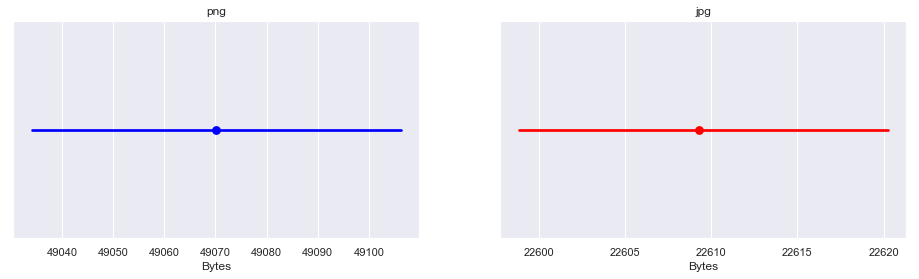

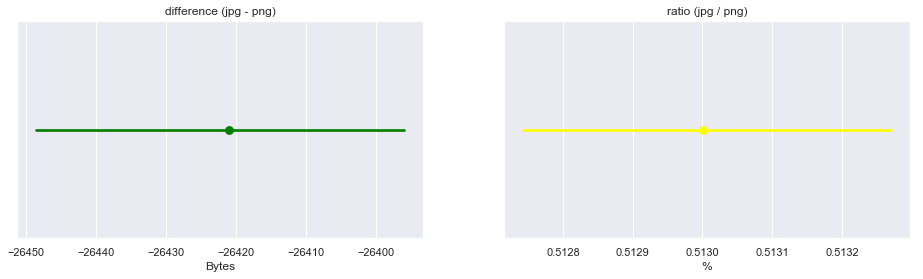

In [22]:
# Percentile Confidence Interval

percent = 95
left_tail = (100 - percent) / 2
right_tail = 100 - left_tail


ci_dict = {
    "png": {
        "left": int(np.percentile(data_png, left_tail)),
        "right": int(np.percentile(data_png, right_tail))
    },
    "jpg": {
        "left":int(np.percentile(data_jpg, left_tail)),
        "right": int(np.percentile(data_jpg, right_tail))
    },
    "diff": {
        "left": int(np.percentile(data_diff, left_tail)),
        "right": int(np.percentile(data_diff, right_tail))
    },
    "ratio": {
        "left": int(np.percentile(data_ratio, left_tail)),
        "right": int(np.percentile(data_ratio, right_tail))
    }    
}

# png
print('The estimated png image byte size: ')
print('  In range of ["{}", "{}"] in {}% chance.'.format(convert_size(ci_dict['png']['left']),convert_size(ci_dict['png']['right']), percent))

# jpg
print('The estimated jpg image byte size: ') 
print('  In range of ["{}", "{}"] in {}% chance.'.format(convert_size(ci_dict['jpg']['left']),convert_size(ci_dict['jpg']['right']), percent))

# diff
print('The estimated image byte size diff: ') 
print('  In range of ["{}", "{}"] in {}% chance.'.format(convert_size(ci_dict['diff']['left']),convert_size(ci_dict['diff']['right']), percent))

# ratio
#print('The estimated image byte size diff: ') 
#print('  In range of ["{}", "{}"] in {}% chance.'.format(convert_size(ci_dict['ratio']['left']),convert_size(ci_dict['ratio']['right']), percent))

# Display two plots side by side
plt.figure(figsize=(16,4))
plt.title("Average image size")

# subplot
plt.subplot(1,2,1)   # row,column, nth
sns.pointplot(data_png, ci=percent, color="blue", annot=True)
plt.title("png")
plt.xlabel('Bytes')

# subplot
plt.subplot(1,2,2) # row,column, nth
sns.pointplot(data_jpg, ci=percent, color="red")
plt.title("jpg")
plt.xlabel('Bytes')


# Diff - Ratio
plt.figure(figsize=(16,4))
# subplot
plt.subplot(1,2,1) # row,column, nth
sns.pointplot(data_diff, ci=percent, color="green")
plt.title("difference (jpg - png)")
plt.xlabel('Bytes')
# subplot
plt.subplot(1,2,2) # row,column, nth
sns.pointplot(data_ratio, ci=percent, color="yellow")
plt.title("ratio (jpg / png)")
plt.xlabel('%')

##### Estimate the total size of 10K images (for embedded database)

In [23]:
# Percentile Confidence Interval

number_image = 10000

# png
print('The estimated png image byte size: ')
print('  In range of ["{}", "{}"] in {}% chance.'\
      .format(convert_size(ci_dict['png']['left'] * number_image),convert_size(ci_dict['png']['right'] * number_image), percent))

# jpg
print('The estimated jpg image byte size: ') 
print('  In range of ["{}", "{}"] in {}% chance.'\
      .format(convert_size(ci_dict['jpg']['left'] * number_image),convert_size(ci_dict['jpg']['right'] * number_image), percent))

# diff
print('The estimated image byte size diff: ') 
print('  In range of ["{}", "{}"] in {}% chance.'\
      .format(convert_size(ci_dict['diff']['left'] * number_image),convert_size(ci_dict['diff']['right'] * number_image), percent))


The estimated png image byte size: 
  In range of ["435.09 MB", "502.53 MB"] in 95% chance.
The estimated jpg image byte size: 
  In range of ["204.47 MB", "226.38 MB"] in 95% chance.
The estimated image byte size diff: 
  In range of ["-277.61 MB", "-227.54 MB"] in 95% chance.


---
# **IMAGE QUALITY CHECK**:

### Compare `png` and `jpg` image files for the same radio station
    - see if there are any noticable `image quality degradation`(from human eyes on the screen).

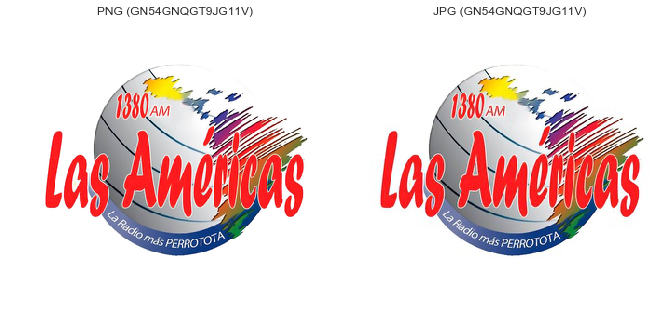

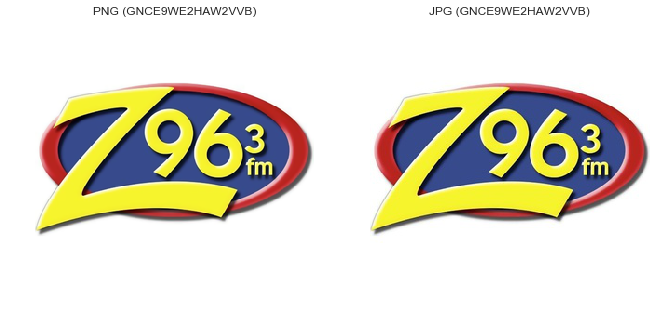

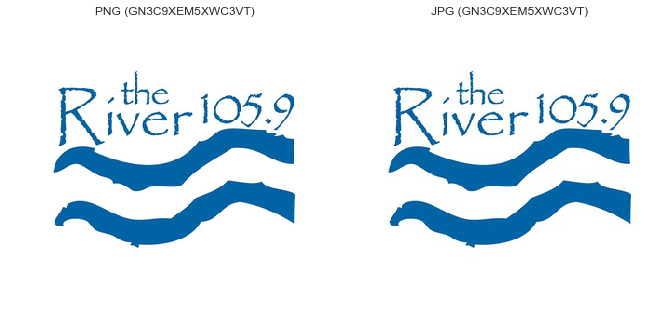

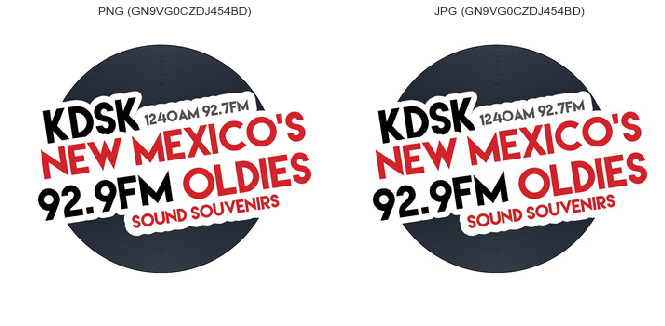

In [24]:
# Randomly pick 4 logo_id
list_review_logo_id = df_sample_data.sample(4)['logo_id'].tolist()
list_review_logo_id

def display_png_jpg_images(list_logo_ids):
    pil_image_list = []
    for logo_graceote_id in list_logo_ids:
        #print(logo_graceote_id)
        
        # open image files
        png_file = 'rsid_logo_' + logo_graceote_id + '.png'
        jpg_file = 'rsid_logo_' + logo_graceote_id + '.jpg'
        try:
            # <image data>
            im_png = Image.open(path_dir_png + png_file)
            im_jpg = Image.open(path_dir_jpg + jpg_file)
            
            pil_image_list.append((im_png,im_jpg))
        except IOError:
            print("error occured...", logo_file)   
            
        # Display two images side by side
        plt.figure(figsize=(11,11))
        plt.title('logo_graceote_id')

        # subplot
        plt.subplot(1,2,1)   # row,column, nth
        plt.imshow(im_png)
        plt.title("PNG (" + logo_graceote_id + ")")
        plt.axis('off')

        # subplot
        plt.subplot(1,2,2) # row,column, nth
        plt.imshow(im_jpg)
        plt.title("JPG (" + logo_graceote_id + ")")
        plt.axis('off')                
            
    #print(image_list)

    
# Execute
display_png_jpg_images(list_review_logo_id)

### IMAGE QUALITY CHECK RESULTS => `JPG` looks totally fine! (not noticable image quality degradation)

---

# Conclusion
The two hypotheses were succesfully validated (both are correct). It's recommended to switch to jpg` format from `png` for the use cases. 
* In `95%` chance `jpg` format is `53% smaller` (`26.07~22.85 KB smaller`) per a image over `png` format 
* Total file size for `10K` stations would be:
    - `png`: `435 ~ 502 MB` in `95%` chance
    - `jpg`: `204 ~ 226 MB` in `95%` chance (`227 ~ 277 MB smaller`)
    
* `No significant image quality degraration is expected` by converting to `jpg` from `png`
    - If lower the quality, the image byte size could be even smaller.


---


## Validated hypotheses with the experiement: 
A) It's better to use jpg format instead of png because it's smaller file size (in average)

    - Smaller file size: Better for data bandwidth
    - Samller file size: Better for storage (i.e. storing 100K images in embedded database)

B) There won't be significant image quality degradation

    - No significant change for human eyes by switching the image format from png to jpg.
    - Note: Thhis would depend on the conversion method (esp quality)